# Maximal Lyapunov exponent (MLE)

In [45]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random
from scipy.spatial import distance

import sys
sys.path.append('/home/sol/Escritorio/paper_reservoir/')


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction

In [46]:
GRN_systems = [grn for index, grn in enumerate(grn_networks.grn_names)
                   if grn.lower()=='ecocyc']
graph = grn_networks.load_network(GRN_systems[0])
graph = nt.prune_graph(graph, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [3]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
# INPUTS
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
num_trials = size
# MATRIZ RESERVORIO 
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)


In [4]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)
mem_capac_spectral = []
std_dev_res = []
for SR_scale in array_SR_values:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    # generate dataset
    sample_len = 1000
    nsamples = 10
    inp_d = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
    # echo state property
    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
    spectral_radius = get_spectral_radius(weights)
    weights *= SR_scale / spectral_radius
    # input
    in_scaling = 0.05
    in_weight = inputs_arr * in_scaling
    input_weights = in_weight.T 
    input_signal = inp_d[0].ravel()
    nnodes = weights.shape[0]
    input_signal = (input_signal[:, None] if input_signal.ndim == 1
                    else input_signal)
    tsteps, nstreams = input_signal.shape
    input_weights = np.atleast_2d(input_weights)
    # Pointers for internal use
    node_function =  np.tanh
    matrix_product = np.dot
    dynamics = np.zeros((tsteps+1, nnodes))

    input_per_node = matrix_product(input_signal, input_weights)
    # unperturbed trajectory
    for t in range(0, input_signal.shape[0]):
        dynamics[t+1, :] = node_function(
                                matrix_product(dynamics[t, :], weights.T)
                                + input_per_node[t])

    unperturbed = dynamics[1:, :]
    node_ix = random.randint(0, nnodes-1)
    initsteps = 10
    #perturbed
    perturbed_dyamics = np.zeros((tsteps+1, nnodes))
    perturbed_dyamics[:int(1+initsteps), :] = unperturbed[:int(1+initsteps), :]
    perturbed_dyamics[int(initsteps), node_ix] += 10**(-0.5)
    gamma_cero = distance.euclidean(perturbed_dyamics[int(initsteps), :], unperturbed[int(initsteps), :] )
    gammas_t_list = []
    for t in range(int(initsteps), input_signal.shape[0]-1):
        perturbed_dyamics[t+1, :] = node_function(
                                matrix_product(perturbed_dyamics[t, :], weights)
                                + input_per_node[t])
        gamma_t = distance.euclidean(perturbed_dyamics[t+1, :], unperturbed[t+1, :] )
        gammas_t_list.append(np.log(gamma_t/gamma_cero))
        perturbed_dyamics[t+1, :] = unperturbed[t+1, :] + gamma_cero*(perturbed_dyamics[t+1, :] - unperturbed[t+1, :])/gamma_t
    mem_capac_spectral.append(np.mean(gammas_t_list))


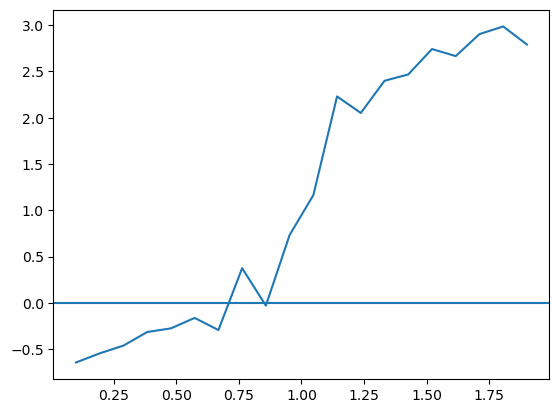

In [6]:
import matplotlib.pyplot as plt 
plt.plot(array_SR_values , mem_capac_spectral)
plt.axhline(y=0)

# Saco lo random afuera

In [47]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
# INPUTS
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
if rand_inputs:
    np.random.shuffle(inputs_arr)
num_trials = size
# MATRIZ RESERVORIO 
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)
# generate dataset
sample_len = 1000
nsamples = 10
inp_d = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
# MATRIZ RESERVORIO 
weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
# input
in_scaling = 0.05
in_weight = inputs_arr * in_scaling
input_weights = in_weight.T 
input_signal = inp_d[0].ravel()
nnodes = weights.shape[0]
input_signal = (input_signal[:, None] if input_signal.ndim == 1
                else input_signal)
tsteps, nstreams = input_signal.shape
input_weights = np.atleast_2d(input_weights)
# Pointers for internal use
node_function =  np.tanh
matrix_product = np.dot
input_per_node = matrix_product(input_signal, input_weights)

In [48]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)
mem_capac_spectral = []
std_dev_res = []
for SR_scale in array_SR_values:
    # echo state property
    spectral_radius = get_spectral_radius(weights)
    weights *= SR_scale / spectral_radius

    dynamics = np.zeros((tsteps+1, nnodes))

    # unperturbed trajectory
    for t in range(0, input_signal.shape[0]):
        dynamics[t+1, :] = node_function(
                                matrix_product(dynamics[t, :], weights.T)
                                + input_per_node[t])

    unperturbed = dynamics[1:, :]
    node_ix = random.randint(0, nnodes-1)
    initsteps = 10
    #perturbed
    perturbed_dyamics = np.zeros((tsteps+1, nnodes))
    perturbed_dyamics[:int(1+initsteps), :] = unperturbed[:int(1+initsteps), :]
    perturbed_dyamics[int(initsteps), node_ix] += 10**(-0.5)
    gamma_cero = distance.euclidean(perturbed_dyamics[int(initsteps), :], unperturbed[int(initsteps), :] )
    gammas_t_list = []
    for t in range(int(initsteps), input_signal.shape[0]-1):
        perturbed_dyamics[t+1, :] = node_function(
                                matrix_product(perturbed_dyamics[t, :], weights)
                                + input_per_node[t])
        gamma_t = distance.euclidean(perturbed_dyamics[t+1, :], unperturbed[t+1, :] )
        gammas_t_list.append(np.log(gamma_t/gamma_cero))
        perturbed_dyamics[t+1, :] = unperturbed[t+1, :] + gamma_cero*(perturbed_dyamics[t+1, :] - unperturbed[t+1, :])/gamma_t
    mem_capac_spectral.append(np.mean(gammas_t_list))

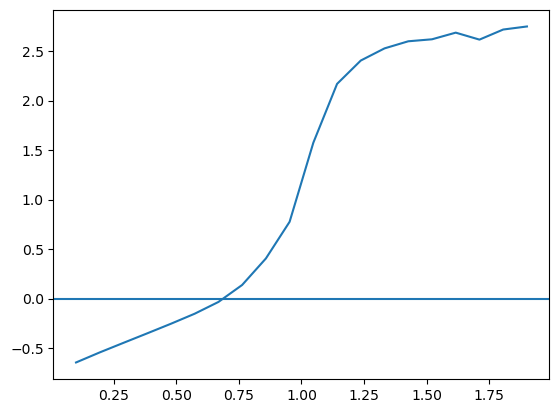

In [49]:
import matplotlib.pyplot as plt 
plt.plot(array_SR_values , mem_capac_spectral)
plt.axhline(y=0)

# Repito para cada spectral radius el procedimiento N=70 veces (nro de nodos)

In [27]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
# INPUTS
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
if rand_inputs:
    np.random.shuffle(inputs_arr)
num_trials = size
# MATRIZ RESERVORIO 
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)
# generate dataset
sample_len = 1000
nsamples = 10
inp_d = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
# MATRIZ RESERVORIO 
weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
# input
in_scaling = 0.05
in_weight = inputs_arr * in_scaling
input_weights = in_weight.T 
input_signal = inp_d[0].ravel()
nnodes = weights.shape[0]
input_signal = (input_signal[:, None] if input_signal.ndim == 1
                else input_signal)
tsteps, nstreams = input_signal.shape
input_weights = np.atleast_2d(input_weights)
# Pointers for internal use
node_function =  np.tanh
matrix_product = np.dot
input_per_node = matrix_product(input_signal, input_weights)

In [39]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)
mem_capac_spectral = []
std_dev_res = []
for SR_scale in array_SR_values:
    # echo state property
    spectral_radius = get_spectral_radius(weights)
    weights *= SR_scale / spectral_radius

    dynamics = np.zeros((tsteps+1, nnodes))

    # unperturbed trajectory
    for t in range(0, input_signal.shape[0]):
        dynamics[t+1, :] = node_function(
                                matrix_product(dynamics[t, :], weights.T)
                                + input_per_node[t])

    unperturbed = dynamics[1:, :]
    results = []
    while len(results) < num_trials:
        node_ix = random.randint(0, nnodes-1)
        initsteps = 10
        #perturbed
        perturbed_dyamics = np.zeros((tsteps+1, nnodes))
        perturbed_dyamics[:int(1+initsteps), :] = unperturbed[:int(1+initsteps), :]
        perturbed_dyamics[int(initsteps), node_ix] += 10**(-0.25)
        gamma_cero = distance.euclidean(perturbed_dyamics[int(initsteps), :], unperturbed[int(initsteps), :] )
        gammas_t_list = []
        for t in range(int(initsteps), input_signal.shape[0]-1):
            perturbed_dyamics[t+1, :] = node_function(
                                    matrix_product(perturbed_dyamics[t, :], weights)
                                    + input_per_node[t])
            gamma_t = distance.euclidean(perturbed_dyamics[t+1, :], unperturbed[t+1, :] )
            gammas_t_list.append(np.log(gamma_t/gamma_cero))
            perturbed_dyamics[t+1, :] = unperturbed[t+1, :] + gamma_cero*(perturbed_dyamics[t+1, :] - unperturbed[t+1, :])/gamma_t
        results.append(np.mean(gammas_t_list))
        print(len(results))
    mem_capac_spectral.append(np.mean(results))
    std_dev_res.append(np.std(results))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
6

In [31]:
std_dev_res

[1.5071529921510351e-05,
 6.364893896504729e-05,
 0.00015679915073293243,
 0.00016689398592125673,
 0.00023149499407978724,
 0.0003828061400415648,
 0.00035804134768605196,
 0.00041061040915054916,
 0.0003886691249883881,
 0.0003216233561734696,
 0.00020175867106358243,
 9.607665989332085e-05,
 8.952117608283437e-05,
 3.19616164489144e-05,
 3.355518191313818e-05,
 1.5778600932215776e-05,
 7.2077271979152e-06,
 8.326893484221664e-06,
 3.1770375363179694e-06,
 9.111031431427573e-06]

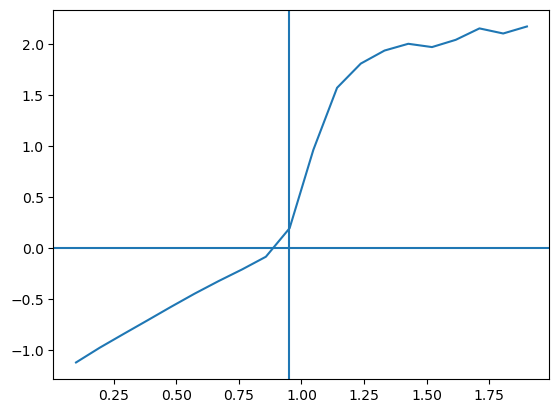

In [40]:
import matplotlib.pyplot as plt 
#plt.plot(array_SR_values , mem_capac_spectral)
plt.errorbar(array_SR_values, mem_capac_spectral, yerr=np.array(std_dev_res), label='both limits (default)')
plt.axhline(y=0)
plt.axvline(x=0.95)

# Now fixed spectral radius, and varied input coupling
On the other hand, increasing the value of ε
can convert an initially expanding mapping into a contracting dynamics, as stronger inputs
tend to push the activities of the reservoir units towards the tails of the non-linearity.

In [114]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
# INPUTS
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
#inputs_arr = 2*np.random.rand(size, 1) - 1.0 # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
if rand_inputs:
    np.random.shuffle(inputs_arr)
num_trials = size
# MATRIZ RESERVORIO 
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)
# generate dataset
sample_len = 1000
nsamples = 10
prngI = np.random.RandomState(42)
inp_d = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
# MATRIZ RESERVORIO 
weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
# input

input_signal = inp_d[0].ravel()
nnodes = weights.shape[0]
input_signal = (input_signal[:, None] if input_signal.ndim == 1
                else input_signal)
tsteps, nstreams = input_signal.shape

# Pointers for internal use
node_function =  np.tanh
matrix_product = np.dot

# echo state property
SR_scale = 0.750
spectral_radius = get_spectral_radius(weights)
weights *= SR_scale / spectral_radius


In [115]:
array_input_coupling = np.linspace(0.01, 1.0, 20)
mem_capac_spectral = []
std_dev_res = []
for in_scaling in array_input_coupling:
    in_weight = inputs_arr * in_scaling
    input_weights = in_weight.T 
    input_weights = np.atleast_2d(input_weights)
    input_per_node = matrix_product(input_signal, input_weights)
    

    dynamics = np.zeros((tsteps+1, nnodes))

    # unperturbed trajectory
    for t in range(0, input_signal.shape[0]):
        dynamics[t+1, :] = node_function(
                                matrix_product(dynamics[t, :], weights.T)
                                + input_per_node[t])

    unperturbed = dynamics[1:, :]
    node_ix = random.randint(0, nnodes-1)
    initsteps = 10
    #perturbed
    perturbed_dyamics = np.zeros((tsteps+1, nnodes))
    perturbed_dyamics[:int(1+initsteps), :] = unperturbed[:int(1+initsteps), :]
    perturbed_dyamics[int(initsteps), node_ix] += 10**(-0.25)
    gamma_cero = distance.euclidean(perturbed_dyamics[int(initsteps), :], unperturbed[int(initsteps), :] )
    gammas_t_list = []
    for t in range(int(initsteps), input_signal.shape[0]-1):
        perturbed_dyamics[t+1, :] = node_function(
                                matrix_product(perturbed_dyamics[t, :], weights)
                                + input_per_node[t])
        gamma_t = distance.euclidean(perturbed_dyamics[t+1, :], unperturbed[t+1, :] )
        gammas_t_list.append(np.log(gamma_t/gamma_cero))
        perturbed_dyamics[t+1, :] = unperturbed[t+1, :] + gamma_cero*(perturbed_dyamics[t+1, :] - unperturbed[t+1, :])/gamma_t
    mem_capac_spectral.append(np.mean(gammas_t_list))

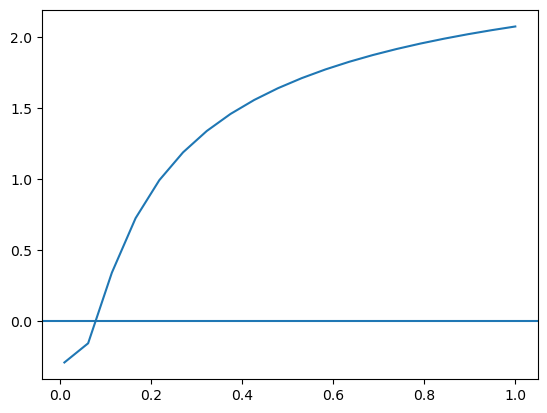

In [116]:
import matplotlib.pyplot as plt 
plt.plot(array_input_coupling , mem_capac_spectral)
plt.axhline(y=0)

# Combinatorial
Chequeo que los 15 nodos de los 70 formen un reservorio? o directamente veo los 15 que me quedan?

In [41]:
# Python3 code to demonstrate working of
# Combinations of elements till size N in list
# Using list comprehension + combinations()
from itertools import combinations

# initializing list
test_list = [4, 5, 6, 7, 3, 8]

# printing original list
print("The original list is : " + str(test_list))

# Combinations of elements till size N in list
# Using list comprehension + combinations()
sub = 3
res = [com for com in combinations(test_list, sub )]

# Printing result
print("The combinations of elements till length N : " + str(res))


The original list is : [4, 5, 6, 7, 3, 8]
The combinations of elements till length N : [(4, 5, 6), (4, 5, 7), (4, 5, 3), (4, 5, 8), (4, 6, 7), (4, 6, 3), (4, 6, 8), (4, 7, 3), (4, 7, 8), (4, 3, 8), (5, 6, 7), (5, 6, 3), (5, 6, 8), (5, 7, 3), (5, 7, 8), (5, 3, 8), (6, 7, 3), (6, 7, 8), (6, 3, 8), (7, 3, 8)]


In [44]:
4*5*6/6

20.0

In [43]:
len(res)

20